In [1]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model
from sklearn.cross_decomposition import PLSRegression
import pandas as pd

c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


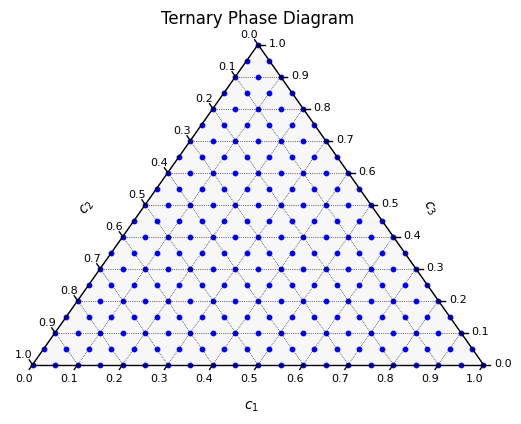

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

def generate_ternary_combinations(step=0.01):
    compositions = np.arange(0, 1 + step, step)
    ternary_combinations = []

    for x in compositions:
        for y in compositions:
            z = 1 - x - y
            if -1e-7 <= z <= 1:
                ternary_combinations.append([x, y, z])
    
    return ternary_combinations

def plot_ternary_diagram(ternary_combinations):
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="black")

    points = np.array(ternary_combinations)
    tax.scatter(points, marker='o', color='blue', s=10)

    tax.set_title("Ternary Phase Diagram")
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
    tax.get_axes().axis('off')
    tax.bottom_axis_label(r"$c_1$", offset=0.05)
    tax.left_axis_label(r"$c_2$", offset=0.14)
    tax.right_axis_label(r"$c_3$", offset=0.14)
    tax.clear_matplotlib_ticks()
    tax.show()


step_size = 0.05
ternary_combinations = generate_ternary_combinations(step_size)
plot_ternary_diagram(ternary_combinations)

In [3]:
c_a, c_b, c_c = [], [], []
for x, y, z in ternary_combinations:
    c_a.append(x)
    c_b.append(y)
    c_c.append(z)

c_a = np.array(c_a)
c_b = np.array(c_b)
c_c = np.array(c_c)

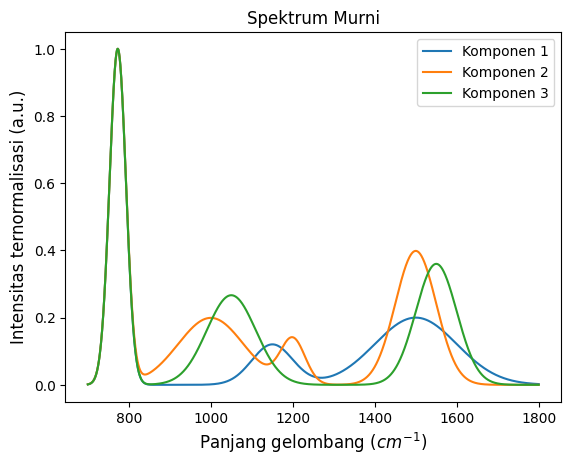

In [36]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(700, 1800, 2000)
# First component
mu_a1 = 773
sigma_a1 = 20
intensity_a1 = 1

mu_a2 = 1150
sigma_a2 = 50
intensity_a2 = 0.3

mu_a3 = 1500
sigma_a3 = 100
intensity_a3 = 1

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 773
sigma_b1 = 20
intensity_b1 = 1

mu_b2 = 1000
sigma_b2 = 80
intensity_b2 = 0.8

mu_b3 = 1200
sigma_b3 = 30
intensity_b3 = 0.2

mu_b4 = 1500
sigma_b4 = 50
intensity_b4 = 1

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 773
sigma_c1 = 20
intensity_c1 = 1

mu_c2 = 1050
sigma_c2 = 60
intensity_c2 = 0.8

mu_c3 = 1550
sigma_c3 = 50
intensity_c3 = 0.9

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2) + Gauss(x_range, mu_c3, sigma_c3, intensity_c3)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Komponen 1')
plt.plot(x_range, component_b, label = 'Komponen 2')
plt.plot(x_range, component_c, label = 'Komponen 3')
plt.title('Spektrum Murni', fontsize = 12)
plt.xlabel(r'Panjang gelombang ($cm^{-1}$)', fontsize = 12)
plt.ylabel('Intensitas ternormalisasi (a.u.)', fontsize = 12)
plt.legend()
plt.show()

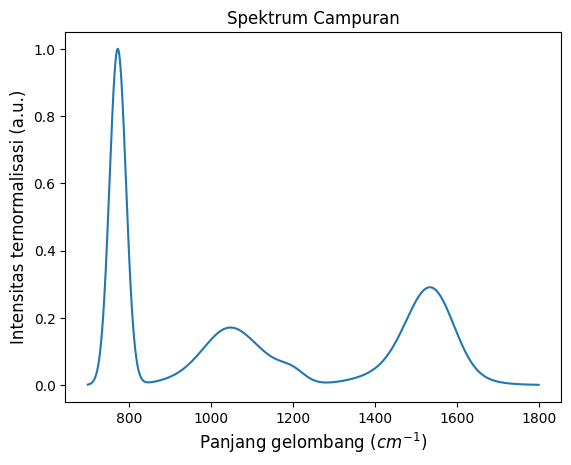

In [37]:
# Mixture
mixture = np.array([c_a, c_b, c_c]).T @ np.array([component_a, component_b, component_c])
# How does it look?
plt.plot(x_range, mixture.T[:,115])
plt.title('Spektrum Campuran', fontsize = 12)
plt.xlabel(r'Panjang gelombang ($cm^{-1}$)', fontsize = 12)
plt.ylabel('Intensitas ternormalisasi (a.u.)', fontsize = 12)
plt.show()


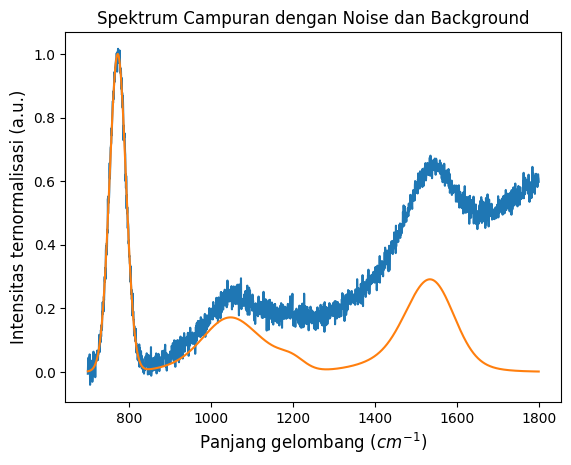

In [38]:
# Let's add some noise for a bit of realism:
clean_mixture = mixture.copy()
# Random noise:
mixture += np.random.normal(0, 0.02, size = mixture.shape)
# Baseline:

# Baseline as a polynomial background:
poly = 0.001 * np.ones(len(x_range)) + 0.000001 * x_range + 0.0000005 * (x_range - 700)**2
mixture += poly

plt.plot(x_range, mixture.T[:,115], label = 'Mixture with noise and baseline')
plt.plot(x_range, clean_mixture.T[:,115], label = 'Mixture')
plt.title('Spektrum Campuran dengan Noise dan Background', fontsize = 12)
plt.xlabel(r'Panjang gelombang ($cm^{-1}$)', fontsize = 12)
plt.ylabel('Intensitas ternormalisasi (a.u.)', fontsize = 12)
plt.show()

In [7]:
# Estimation of the baseline:
# Parameters for this case:
l = 100000000 # smoothness
p = 0.005 # asymmetry
estimated_baselined = []
for i in range(mixture.shape[0]):
    estimated_baselined.append(baseline_als(mixture[i], l, p))
estimated_baselined = np.array(estimated_baselined).T

# Baseline subtraction:
baselined_spectrum = mixture.T - estimated_baselined

# Reasoning baseline + noise

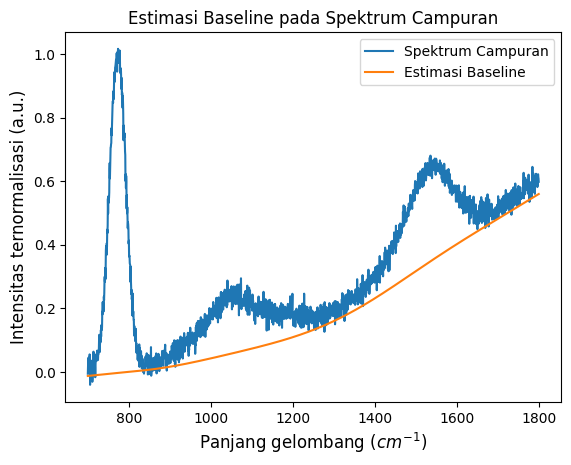

In [39]:
# How does it look like?
plt.plot(x_range, mixture[115].T, label = 'Spektrum Campuran')
plt.plot(x_range, estimated_baselined[:,0], label = 'Estimasi Baseline')
plt.title('Estimasi Baseline pada Spektrum Campuran', fontsize = 12)
plt.xlabel(r'Panjang gelombang ($cm^{-1}$)', fontsize = 12)
plt.ylabel('Intensitas ternormalisasi (a.u.)', fontsize = 12)
plt.legend()
plt.show()

In [9]:
# Parameters:
w = 100 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = []
for i in range(baselined_spectrum.shape[1]):
    smoothed_spectrum.append(savgol_filter(baselined_spectrum[:,i], w, polyorder = p, deriv=0))
smoothed_spectrum = np.array(smoothed_spectrum)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/

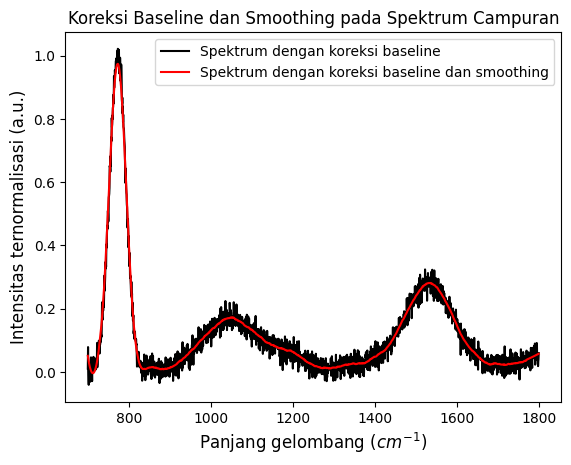

In [40]:
# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum[:,115], color = 'black', label = 'Spektrum dengan koreksi baseline')
plt.plot(x_range, smoothed_spectrum[115], color = 'red', label = 'Spektrum dengan koreksi baseline dan smoothing')
plt.title('Koreksi Baseline dan Smoothing pada Spektrum Campuran', fontsize = 12)
plt.xlabel(r'Panjang gelombang ($cm^{-1}$)', fontsize = 12)
plt.ylabel('Intensitas ternormalisasi (a.u.)', fontsize = 12)
plt.legend()
plt.show()

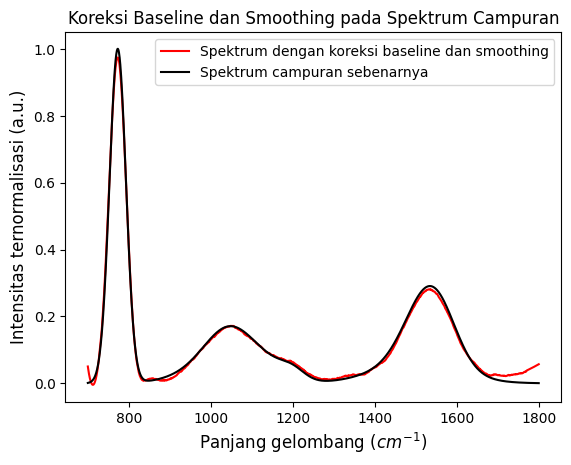

In [41]:
plt.plot(x_range, smoothed_spectrum[115], color = 'red', label = 'Spektrum dengan koreksi baseline dan smoothing')
plt.plot(x_range, clean_mixture.T[:,115], color = 'black', label = 'Spektrum campuran sebenarnya')
plt.title('Koreksi Baseline dan Smoothing pada Spektrum Campuran', fontsize = 12)
plt.xlabel(r'Panjang gelombang ($cm^{-1}$)', fontsize = 12)
plt.ylabel('Intensitas ternormalisasi (a.u.)', fontsize = 12)
plt.legend()
plt.show()

In [11]:
np.array([c_a, c_b, c_c]).T.shape, smoothed_spectrum.shape

((231, 3), (231, 2000))

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = smoothed_spectrum
concentrations = np.array([c_a, c_b, c_c]).T
# Splitting the data into train, validation and test sets:

X_train, X_test, y_train, y_test = train_test_split(X, concentrations, test_size=0.125, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1-150/175, random_state=43)

In [51]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((173, 2000), (29, 2000), (173, 3), (29, 3))

In [52]:
#K Fold Cross Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [63]:
# Find best number of components using PRESS and cross-validation
# Parameters:
n_components = 100 # number of components to test
press_train = []
press_test = []
fold = KFold(n_splits=5, shuffle=True, random_state=42)

for i in range(1, n_components + 1):
    pls = PLSRegression(n_components = i)
    press_train.append(-np.mean(cross_val_score(pls, X_train, y_train, cv=fold, scoring='neg_mean_squared_error')))
    press_test.append(-np.mean(cross_val_score(pls, X_test, y_test, cv=fold, scoring='neg_mean_squared_error')))




c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 22
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 22
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 22
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 22
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\sklearn\

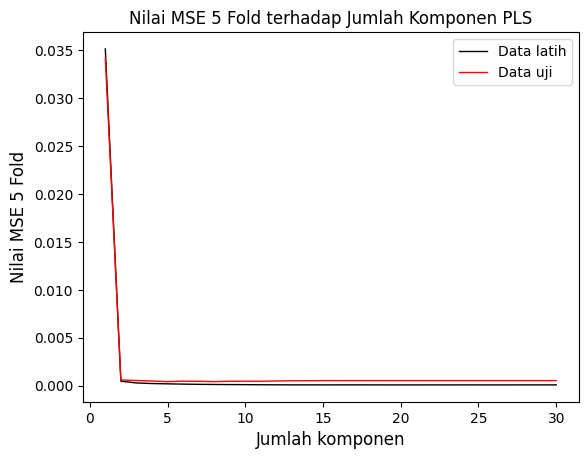

In [65]:
# Plotting the PRESS values for the training and validation sets:
plt.plot(range(1, 31), press_train[:30], label = 'Data latih', linewidth=1, color='black')
plt.plot(range(1, 31), press_test[:30], label = 'Data uji', linewidth=1, color='red')
plt.xlabel('Jumlah komponen', fontsize = 12)
plt.ylabel('Nilai MSE 5 Fold', fontsize = 12)
plt.title('Nilai MSE 5 Fold terhadap Jumlah Komponen PLS', fontsize = 12)
#plt.xticks(range(1, n_components + 1, 5))
plt.legend()
plt.show()

In [85]:
press_train_norm = (press_train - np.min(press_train)) / (np.max(press_train) - np.min(press_train))
press_test_norm = (press_test - np.min(press_test)) / (np.max(press_test) - np.min(press_test))
best_n_components = np.argmin(press_train_norm) + 1
print('The best number of components is:', best_n_components)


The best number of components is: 20


In [111]:
pls = PLSRegression(n_components = best_n_components)
pls.fit(X_train, y_train)
y_pred_train = pls.predict(X_train)
y_pred_val = pls.predict(X_val)
y_pred_test = pls.predict(X_test)

y_pred_train = np.clip(y_pred_train, 0, None)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_test = np.clip(y_pred_test, 0, None)

In [112]:
# Evaluation metrics:
# RMSE:
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
rmse_val = np.sqrt(np.mean((y_pred_val - y_val)**2))
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))

# MAE:
mae_train = np.mean(np.abs(y_pred_train - y_train))
mae_val = np.mean(np.abs(y_pred_val - y_val))
mae_test = np.mean(np.abs(y_pred_test - y_test))

df = pd.DataFrame({'RMSE': [rmse_train, rmse_val, rmse_test], 'MAE': [mae_train, mae_val, mae_test]}, index = ['Train', 'Validation', 'Test'])
df.round(3)

,RMSE,MAE
Train,0.005,0.004
Validation,0.009,0.007
Test,0.008,0.006


In [113]:
# Print some results:
y_test = np.round(y_test, 3)
y_pred_test = np.round(y_pred_test, 3)

df = pd.DataFrame({'Real concentration A': y_test[:,0], 'Predicted concentration A': y_pred_test[:,0], 'Real concentration B': y_test[:,1], 'Predicted concentration B': y_pred_test[:,1], 'Real concentration C': y_test[:,2], 'Predicted concentration C': y_pred_test[:,2]})
# Multi level column names:
df.columns = pd.MultiIndex.from_product([['Concentration A', 'Concentration B', 'Concentration C'], ['Real', 'Predicted']])
df.index += 1
df[:10]

Concentration A           Concentration B           Concentration C  \
              Real Predicted            Real Predicted            Real   
1             0.80     0.807            0.10     0.104            0.10   
2             0.15     0.155            0.30     0.306            0.55   
3             0.00     0.000            0.45     0.474            0.55   
4             0.50     0.502            0.25     0.253            0.25   
5             0.00     0.000            0.75     0.759            0.25   
6             0.65     0.666            0.25     0.238            0.10   
7             0.05     0.043            0.20     0.212            0.75   
8             0.65     0.635            0.05     0.062            0.30   
9             0.45     0.444            0.05     0.047            0.50   
10            0.35     0.347            0.00     0.000            0.65   

              
   Predicted  
1      0.089  
2      0.539  
3      0.533  
4      0.245  
5      0.242  
6      0.096  
7      0.745  
8      0.302  
9      0.509  
10     0.656

c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


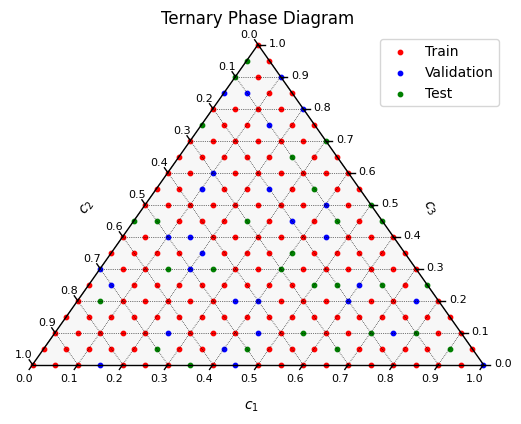

In [114]:
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.1, color="black")

tax.scatter(y_train, marker='o', color='red', s=10, label = 'Train')
tax.scatter(y_val, marker='o', color='blue', s=10, label = 'Validation')
tax.scatter(y_test, marker='o', color='green', s=10, label = 'Test')


tax.set_title("Ternary Phase Diagram")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
tax.get_axes().axis('off')
tax.bottom_axis_label(r"$c_1$", offset=0.05)
tax.left_axis_label(r"$c_2$", offset=0.14)
tax.right_axis_label(r"$c_3$", offset=0.14)
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()

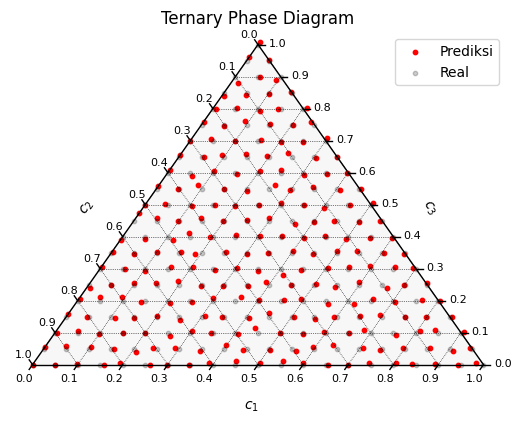

In [116]:
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.1, color="black")


y_pred = np.concatenate((y_pred_train, y_pred_val, y_pred_test), axis = 0)
y = np.concatenate((y_train, y_val, y_test), axis = 0)
tax.scatter(y_pred, marker='o', color='red', s=10, label = 'Prediksi')
tax.scatter(y, marker='o', color='black', s=10, label = 'Real', alpha = 0.2)

tax.set_title("Ternary Phase Diagram")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
tax.get_axes().axis('off')
tax.bottom_axis_label(r"$c_1$", offset=0.05)
tax.left_axis_label(r"$c_2$", offset=0.14)
tax.right_axis_label(r"$c_3$", offset=0.14)
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()
